In [25]:
# Import libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys


# For evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# For loading models
import joblib
from tensorflow.keras.models import load_model


PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../../"))  # go up two levels

# Paths
PROCESSED = os.path.join(PROJECT_ROOT, "data/processed")
MODELS = os.path.join(PROJECT_ROOT, "models")
print("Processed folder:", PROCESSED)


sns.set(style="whitegrid")


Processed folder: /home/burnsmay/cmse492_project/data/processed


In [26]:
# Load test set
X_train = pd.read_csv(os.path.join(PROCESSED, "X_train.csv"))["clean_text"]
y_train = pd.read_csv(os.path.join(PROCESSED, "y_train.csv"))
X_test = pd.read_csv(os.path.join(PROCESSED, "X_test.csv"))["clean_text"]
y_test = pd.read_csv(os.path.join(PROCESSED, "y_test.csv"))



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4549
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8833
   macro avg       0.99      0.99      0.99      8833
weighted avg       0.99      0.99      0.99      8833



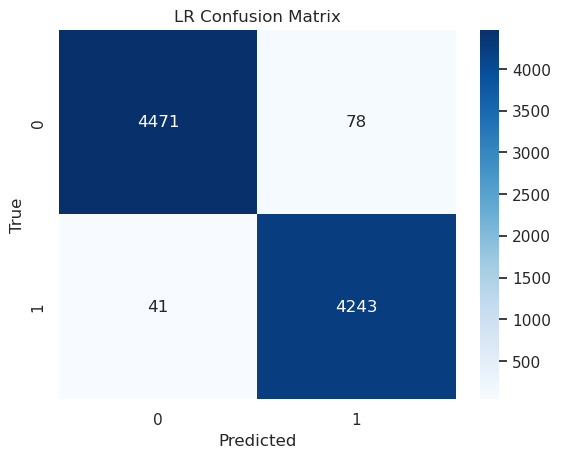

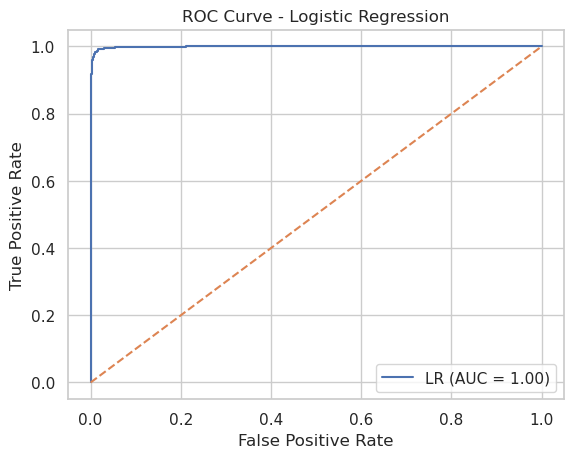

In [28]:
mask_train = X_train.notna()
X_train = X_train[mask_train]
y_train = y_train[mask_train]

mask_test = X_test.notna()
X_test = X_test[mask_test]
y_test = y_test[mask_test]

X_train = X_train.astype(str)
X_test = X_test.astype(str)


# Load model
logreg_model = joblib.load(os.path.join(MODELS, "logreg_model.pkl"))
tfidf = joblib.load(os.path.join(MODELS, "tfidf.pkl"))

# Transform test set
X_test_vec = tfidf.transform(X_test)
y_pred = logreg_model.predict(X_test_vec)

# Metrics
print("=== Logistic Regression ===")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("LR Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, logreg_model.predict_proba(X_test_vec)[:,1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"LR (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


=== Linear SVM ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4549
           1       0.99      0.99      0.99      4284

    accuracy                           0.99      8833
   macro avg       0.99      0.99      0.99      8833
weighted avg       0.99      0.99      0.99      8833



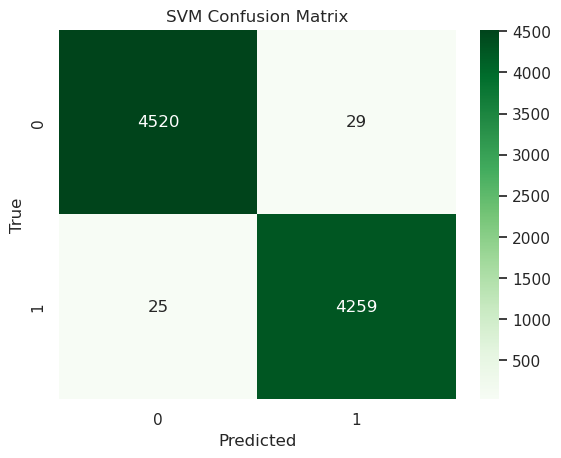

In [29]:
# Load SVM model and TF-IDF vectorizer
svm_model = joblib.load(os.path.join(MODELS, "svm_model.pkl"))
tfidf = joblib.load(os.path.join(MODELS, "tfidf.pkl"))  # make sure it's the same vectorizer

# Prepare test set (drop NaNs and convert to string)
test_df = pd.concat([X_test, y_test], axis=1).dropna()
X_test_svm = test_df["clean_text"].astype(str)
y_test_svm = test_df[y_test.columns[0]].values.ravel()

# Transform test set
X_test_vec_svm = tfidf.transform(X_test_svm)
y_pred_svm = svm_model.predict(X_test_vec_svm)

# Metrics
print("=== Linear SVM ===")
print(classification_report(y_test_svm, y_pred_svm))

# Confusion matrix
cm_svm = confusion_matrix(y_test_svm, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Greens")
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_WORDS = 20000
MAX_LEN = 300
# Load BiLSTM model
bilstm_model = load_model(os.path.join(MODELS, "bilstm_model.h5"))

# Tokenizer from training (you might need to save/load it if used)
tokenizer = joblib.load(os.path.join(MODELS, "tokenizer.pkl"))

# Prepare test data
X_test_bilstm = X_test.astype(str)
X_test_seq = tokenizer.texts_to_sequences(X_test_bilstm)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

# Predict
y_pred_bilstm_prob = bilstm_model.predict(X_test_pad)
y_pred_bilstm = (y_pred_bilstm_prob > 0.5).astype(int)

# Metrics
print("=== BiLSTM ===")
print(classification_report(y_test, y_pred_bilstm))

# Confusion matrix
cm_bilstm = confusion_matrix(y_test, y_pred_bilstm)
sns.heatmap(cm_bilstm, annot=True, fmt="d", cmap="Oranges")
plt.title("BiLSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_bilstm_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"BiLSTM (AUC = {roc_auc:.2f})")
plt.plot([0,1],[0,1],'--')
plt.title("ROC Curve - BiLSTM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


214/277 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step